In [3]:
import numpy as np
np.random.seed(42)

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()

X_original = np.array(data['data'])
Y_original = np.array(data['target'], dtype=int)

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(X_original, Y_original):
    X_train, Y_train = X_original[train_index, :], Y_original[train_index]
    X_test, Y_test = X_original[test_index, :], Y_original[test_index]
    
X_train, Y_train = X_original, Y_original
X_test, Y_test = X_original, Y_original

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([('std_scaler', StandardScaler())])
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train_scaled)

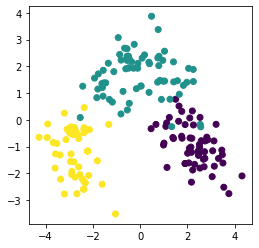

In [6]:
plt.figure(figsize=(4, 4))
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c=Y_train)
plt.show()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(3)
knn.fit(X_train_scaled, Y_train)
Y_test_pred = knn.predict(X_test_scaled)
accuracy_score(Y_test, Y_test_pred)

0.9606741573033708

In [8]:
class ReLU():
    def __init__(self, offset=0):
        self.offset = offset
        
    def loss(self, X):
        return np.maximum(X + self.offset, 0)
    
    def grad(self, X):
        return (X + self.offset) > 0
        
class LeakyReLU():
    def __init__(self, offset=0, alpha=1e-2):
        self.offset = offset
        self.alpha = alpha
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, Xo, self.alpha * Xo)
    
    def grad(self, X):
        return np.where(X + self.offset > 0, 1, self.alpha)
        
class SmoothReLU():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, Xo, np.where(Xo > -.5, .5 * (Xo + .5) ** 2, 0))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, 1, np.where(Xo > -.5, Xo + .5, 0))
    
class LeakySmoothReLU():
    def __init__(self, offset=0, alpha=1e-2):
        assert alpha <= 1
        
        self.offset = offset
        self.alpha = alpha
        self.a = alpha - .5
        self.b = .5 * (alpha - alpha ** 2)
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, Xo, np.where(Xo > self.a, .5 * (Xo + .5) ** 2, self.alpha * Xo + self.b))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, 1, np.where(Xo > self.a, Xo + .5, self.alpha))

class SmoothReLU2():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, Xo, np.where(Xo > 0, -2 / 3 *  (Xo + .5) ** 3 + 2 * (Xo + .5) ** 2 - Xo - 1 / 3,
                                              np.where(Xo > -.5, 2 / 3 * (Xo + .5) ** 3, 0)))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, 1, np.where(Xo > 0, 1 - 2 * (Xo - .5) ** 2,
                                             np.where(Xo > -.5, 2 * (Xo + .5) ** 2, 0)))
    
class LeakySmoothReLU2():
    def __init__(self, offset=0, alpha=1e-2):
        assert 0 <= alpha <= .5
        
        self.offset = offset
        self.alpha = alpha
        self.a = (.5 * alpha) ** .5 - .5
        self.b = .5 * alpha - 2 ** .5 / 3 * alpha ** 1.5
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, Xo, np.where(Xo > 0, -2 / 3 *  (Xo + .5) ** 3 + 2 * (Xo + .5) ** 2 - Xo - 1 / 3,
                                              np.where(Xo > self.a, 2 / 3 * (Xo + .5) ** 3, self.alpha * Xo + self.b)))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > .5, 1, np.where(Xo > 0, 1 - 2 * (Xo - .5) ** 2,
                                             np.where(Xo > self.a, 2 * (Xo + .5) ** 2, self.alpha)))

class SmoothReLU3():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, np.log((1 + np.exp(4 * Xo)) / 2) / 4 + 1 / 6, np.where(Xo > -1, (Xo + 1) ** 3 / 6, 0))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, 1 - 1 / (1 + np.exp(4 * Xo)), np.where(Xo > -1, (Xo + 1) ** 2 / 2, 0))
    
class LeakySmoothReLU3():
    def __init__(self, offset=0, alpha=1e-2):
        assert 0 <= alpha <= .5
        
        self.offset = offset
        self.alpha = alpha
        self.a = (2 * alpha) ** .5 - 1 
        self.b = alpha - 2 / 3 * 2 ** .5 * alpha ** 1.5
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, np.log((1 + np.exp(4 * Xo)) / 2) / 4 + 1 / 6,
                        np.where(Xo > self.a, (Xo + 1) ** 3 / 6, self.alpha * Xo + self.b))
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, 1 - 1 / (1 + np.exp(4 * Xo)),
                        np.where(Xo > self.a, (Xo + 1) ** 2 / 2, self.alpha))
    
class Quadratic():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, Xo ** 2, 0)
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > 0, 2 * Xo, 0)
    
class LeakyQuadratic():
    def __init__(self, offset=0, alpha=1e-2):
        self.offset = offset
        self.alpha = alpha
        self.a = .5 * alpha
        self.b = -((.5 * alpha) ** 2)
    
    def loss(self, X):
        Xo = X + self.offset
        return np.where(Xo > self.a, Xo ** 2, self.alpha * Xo + self.b)
    
    def grad(self, X):
        Xo = X + self.offset
        return np.where(Xo > self.a, 2 * Xo, self.alpha)

class Logistic():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        Xo = 4 * (X + self.offset)
        Y = np.exp(Xo)
        return np.where(np.isposinf(Y), Xo, .25 * np.log1p(Y))
    
    def grad(self, X):
        Xo = 4 * (X + self.offset)
        Y = np.exp(Xo)
        return np.where(np.isposinf(Y), 1, 1 - 1 / (1 + Y))

class LeakyLogistic():
    def __init__(self, offset=0, alpha=1e-2):
        assert 0 <= alpha < 1
        
        self.offset = offset
        self.alpha = alpha
        self.a = -np.inf if alpha == 0 else np.log(alpha / (1 - alpha))
        self.b = 0 if alpha == 0 else .25 * (np.log(1 / (1 - alpha)) - alpha * np.log(alpha / (1 - alpha)))
    
    def loss(self, X):
        Xo = 4 * (X + self.offset)
        Y = np.exp(Xo)
        return np.where(Xo > self.a, np.where(np.isposinf(Y), Xo, .25 * np.log1p(Y)), .25 * self.alpha * Xo + self.b)
    
    def grad(self, X):
        Xo = 4 * (X + self.offset)
        Y = np.exp(Xo)
        return np.where(Xo > self.a, np.where(np.isposinf(Y), 1, 1 - 1 / (1 + Y)), self.alpha)

class Sigmoid():
    def __init__(self, offset=0):
        self.offset = offset
    
    def loss(self, X):
        return 1 / (1 + np.exp(-4 * (X + self.offset)))

    def grad(self, X):
        Y = 1 / (1 + np.exp(-4 * (X + self.offset)))
        return 4 * Y * (1 - Y)
    
class LeakySigmoid():
    def __init__(self, offset=0, alpha=1e-2, beta=1e-2):
        assert 0 <= alpha <= 1
        assert 0 <= beta <= 1
        
        self.offset = offset
        self.alpha = alpha
        self.beta = beta
        self.a = -np.inf if alpha == 0 else np.log((-alpha - 2 * (1 - alpha) ** .5 + 2) / alpha)
        self.b = 0 if alpha == 0 else 1 - (1 / (1 - alpha / (alpha - 2 * (1 - alpha) ** .5 - 2)) -
                                           .25 * alpha * np.log((-alpha + 2 * (1 - alpha) ** .5 + 2) / alpha))
        self.c = np.inf if beta == 0 else np.log((-beta + 2 * (1 - beta) ** .5 + 2) / beta)
        self.d = 1 if beta == 0 else (1 / (1 - beta / (beta - 2 * (1 - beta) ** .5 - 2)) -
                                      .25 * beta * np.log((-beta + 2 * (1 - beta) ** .5 + 2) / beta))

        
    def loss(self, X):
        Xo = 4 * (X + self.offset)
        return np.where(Xo > self.c, .25 * self.beta * Xo + self.d,
                        np.where(Xo > self.a, 1 / (1 + np.exp(-Xo)), .25 * self.alpha * Xo + self.b))
    
    def grad(self, X):
        Xo = 4 * (X + self.offset)
        Y = 1 / (1 + np.exp(-Xo))
        return np.where(Xo > self.c, self.beta, np.where(Xo > self.a, 4 * Y * (1 - Y), self.alpha))

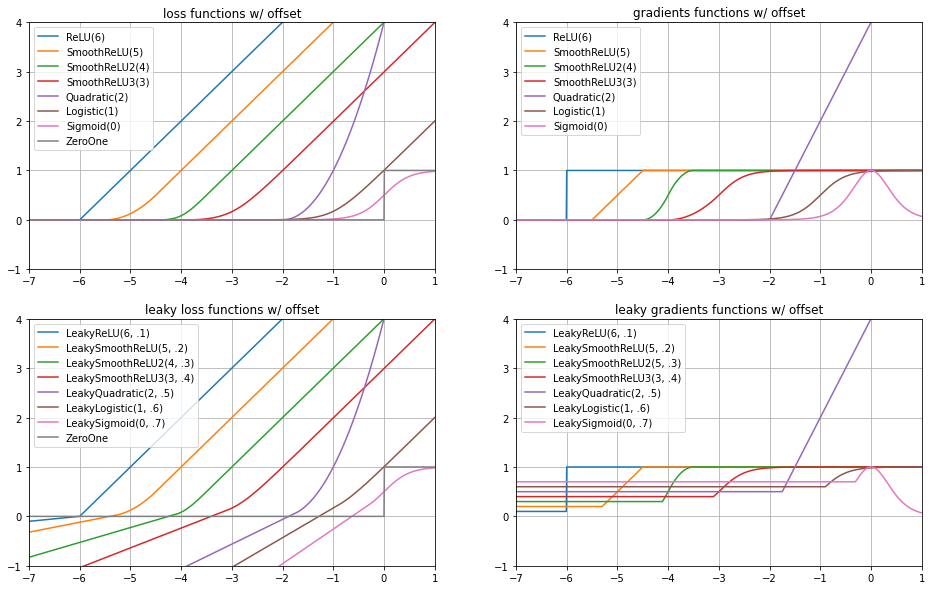

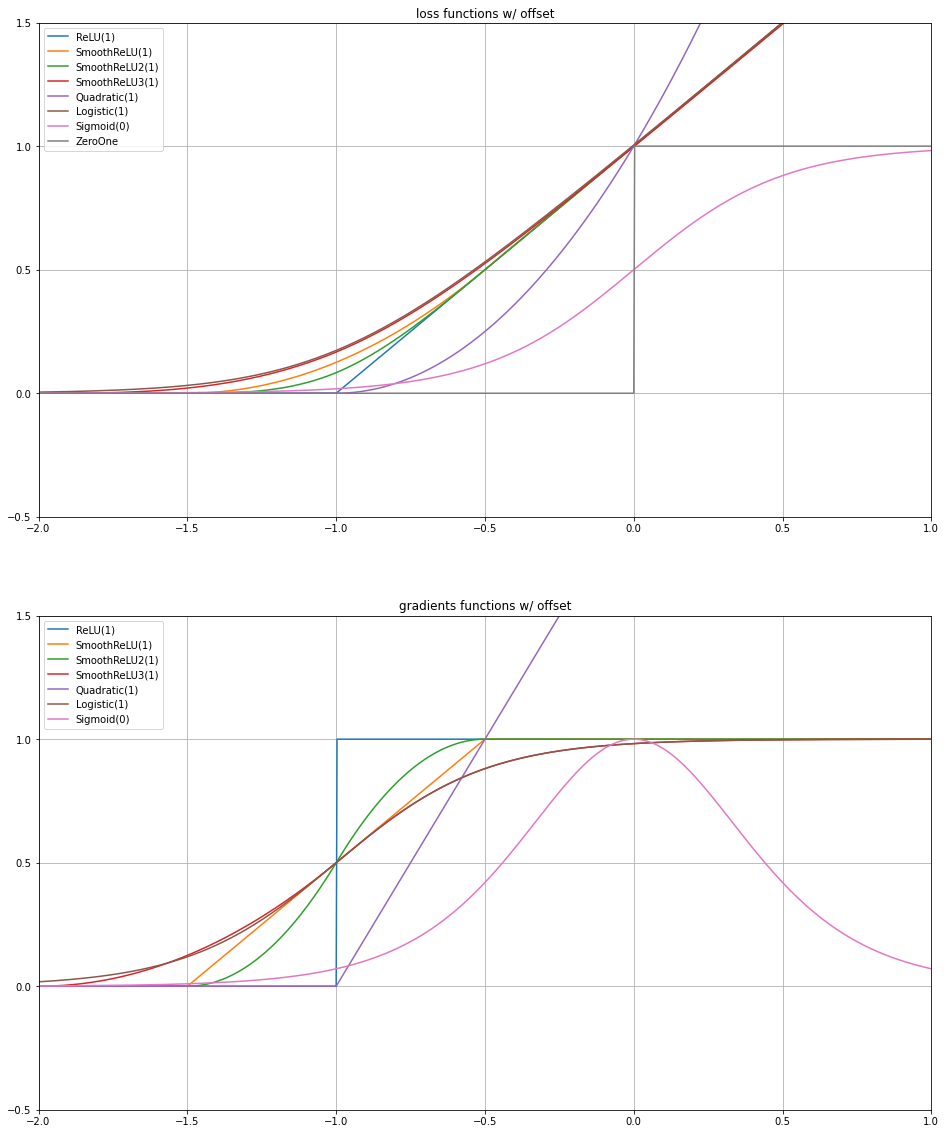

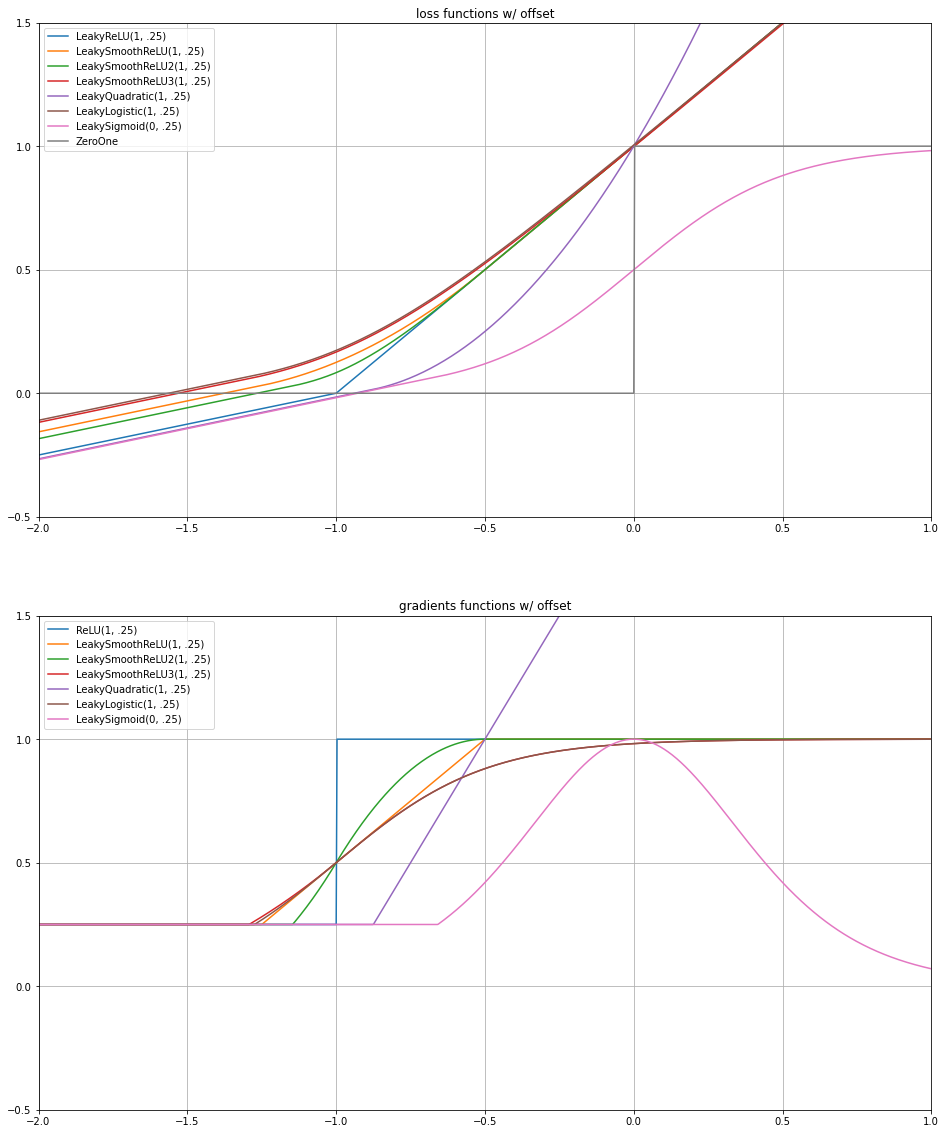

In [9]:
zero_one = lambda x : np.where(x > 0, 1, 0)
relu = ReLU(6)
smooth_relu = SmoothReLU(5)
smooth_relu_2 = SmoothReLU2(4)
smooth_relu_3 = SmoothReLU3(3)
quadratic = Quadratic(2)
logistic = Logistic(1)
sigmoid = Sigmoid(0)
leaky_relu = LeakyReLU(6, .1)
leaky_smooth_relu = LeakySmoothReLU(5, .2)
leaky_smooth_relu_2 = LeakySmoothReLU2(4, .3)
leaky_smooth_relu_3 = LeakySmoothReLU3(3, .4)
leaky_quadratic = LeakyQuadratic(2, .5)
leaky_logistic = LeakyLogistic(1, .6)
leaky_sigmoid = LeakySigmoid(0, .7)

x = np.linspace(-7, 1, 1024, endpoint=True)

plt.figure(figsize=(16, 10))

plt.subplot(221)
plt.plot(x, relu.loss(x), label='ReLU(6)')
plt.plot(x, smooth_relu.loss(x), label='SmoothReLU(5)')
plt.plot(x, smooth_relu_2.loss(x), label='SmoothReLU2(4)')
plt.plot(x, smooth_relu_3.loss(x), label='SmoothReLU3(3)')
plt.plot(x, quadratic.loss(x), label='Quadratic(2)')
plt.plot(x, logistic.loss(x), label='Logistic(1)')
plt.plot(x, sigmoid.loss(x), label='Sigmoid(0)')
plt.plot(x, zero_one(x), label='ZeroOne')
plt.title("loss functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-7, 1)
plt.ylim(-1, 4)
plt.grid()

plt.subplot(222)
plt.plot(x, relu.grad(x), label='ReLU(6)')
plt.plot(x, smooth_relu.grad(x), label='SmoothReLU(5)')
plt.plot(x, smooth_relu_2.grad(x), label='SmoothReLU2(4)')
plt.plot(x, smooth_relu_3.grad(x), label='SmoothReLU3(3)')
plt.plot(x, quadratic.grad(x), label='Quadratic(2)')
plt.plot(x, logistic.grad(x), label='Logistic(1)')
plt.plot(x, sigmoid.grad(x), label='Sigmoid(0)')
plt.title("gradients functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-7, 1)
plt.ylim(-1, 4)
plt.grid()

plt.subplot(223)
plt.plot(x, leaky_relu.loss(x), label='LeakyReLU(6, .1)')
plt.plot(x, leaky_smooth_relu.loss(x), label='LeakySmoothReLU(5, .2)')
plt.plot(x, leaky_smooth_relu_2.loss(x), label='LeakySmoothReLU2(4, .3)')
plt.plot(x, leaky_smooth_relu_3.loss(x), label='LeakySmoothReLU3(3, .4)')
plt.plot(x, leaky_quadratic.loss(x), label='LeakyQuadratic(2, .5)')
plt.plot(x, leaky_logistic.loss(x), label='LeakyLogistic(1, .6)')
plt.plot(x, leaky_sigmoid.loss(x), label='LeakySigmoid(0, .7)')
plt.plot(x, zero_one(x), label='ZeroOne')
plt.title("leaky loss functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-7, 1)
plt.ylim(-1, 4)
plt.grid()

plt.subplot(224)
plt.plot(x, leaky_relu.grad(x), label='LeakyReLU(6, .1)')
plt.plot(x, leaky_smooth_relu.grad(x), label='LeakySmoothReLU(5, .2)')
plt.plot(x, leaky_smooth_relu_2.grad(x), label='LeakySmoothReLU2(5, .3)')
plt.plot(x, leaky_smooth_relu_3.grad(x), label='LeakySmoothReLU3(3, .4)')
plt.plot(x, leaky_quadratic.grad(x), label='LeakyQuadratic(2, .5)')
plt.plot(x, leaky_logistic.grad(x), label='LeakyLogistic(1, .6)')
plt.plot(x, leaky_sigmoid.grad(x), label='LeakySigmoid(0, .7)')
plt.title("leaky gradients functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-7, 1)
plt.ylim(-1, 4)
plt.grid()

zero_one = lambda x : np.where(x > 0, 1, 0)
relu = ReLU(1)
smooth_relu = SmoothReLU(1)
smooth_relu_2 = SmoothReLU2(1)
smooth_relu_3 = SmoothReLU3(1)
quadratic = Quadratic(1)
logistic = Logistic(1)
sigmoid = Sigmoid(0)

x = np.linspace(-2, 1, 1024, endpoint=True)

plt.figure(figsize=(16, 20))

plt.subplot(211)
plt.plot(x, relu.loss(x), label='ReLU(1)')
plt.plot(x, smooth_relu.loss(x), label='SmoothReLU(1)')
plt.plot(x, smooth_relu_2.loss(x), label='SmoothReLU2(1)')
plt.plot(x, smooth_relu_3.loss(x), label='SmoothReLU3(1)')
plt.plot(x, quadratic.loss(x), label='Quadratic(1)')
plt.plot(x, logistic.loss(x), label='Logistic(1)')
plt.plot(x, sigmoid.loss(x), label='Sigmoid(0)')
plt.plot(x, zero_one(x), label='ZeroOne')
plt.title("loss functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-2, 1)
plt.ylim(-.5, 1.5)
plt.yticks([-.5, 0, .5, 1, 1.5])
plt.grid()

plt.subplot(212)
plt.plot(x, relu.grad(x), label='ReLU(1)')
plt.plot(x, smooth_relu.grad(x), label='SmoothReLU(1)')
plt.plot(x, smooth_relu_2.grad(x), label='SmoothReLU2(1)')
plt.plot(x, smooth_relu_3.grad(x), label='SmoothReLU3(1)')
plt.plot(x, quadratic.grad(x), label='Quadratic(1)')
plt.plot(x, logistic.grad(x), label='Logistic(1)')
plt.plot(x, sigmoid.grad(x), label='Sigmoid(0)')
plt.title("gradients functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-2, 1)
plt.ylim(-.5, 1.5)
plt.yticks([-.5, 0, .5, 1, 1.5])
plt.grid()

zero_one = lambda x : np.where(x > 0, 1, 0)
leaky_relu = LeakyReLU(1, .25)
leaky_smooth_relu = LeakySmoothReLU(1, .25)
leaky_smooth_relu_2 = LeakySmoothReLU2(1, .25)
leaky_smooth_relu_3 = LeakySmoothReLU3(1, .25)
leaky_quadratic = LeakyQuadratic(1, .25)
leaky_logistic = LeakyLogistic(1, .25)
leaky_sigmoid = LeakySigmoid(0, .25)

x = np.linspace(-2, 1, 1024, endpoint=True)

plt.figure(figsize=(16, 20))

plt.subplot(211)
plt.plot(x, leaky_relu.loss(x), label='LeakyReLU(1, .25)')
plt.plot(x, leaky_smooth_relu.loss(x), label='LeakySmoothReLU(1, .25)')
plt.plot(x, leaky_smooth_relu_2.loss(x), label='LeakySmoothReLU2(1, .25)')
plt.plot(x, leaky_smooth_relu_3.loss(x), label='LeakySmoothReLU3(1, .25)')
plt.plot(x, leaky_quadratic.loss(x), label='LeakyQuadratic(1, .25)')
plt.plot(x, leaky_logistic.loss(x), label='LeakyLogistic(1, .25)')
plt.plot(x, leaky_sigmoid.loss(x), label='LeakySigmoid(0, .25)')
plt.plot(x, zero_one(x), label='ZeroOne')
plt.title("loss functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-2, 1)
plt.ylim(-.5, 1.5)
plt.yticks([-.5, 0, .5, 1, 1.5])
plt.grid()

plt.subplot(212)
plt.plot(x, leaky_relu.grad(x), label='ReLU(1, .25)')
plt.plot(x, leaky_smooth_relu.grad(x), label='LeakySmoothReLU(1, .25)')
plt.plot(x, leaky_smooth_relu_2.grad(x), label='LeakySmoothReLU2(1, .25)')
plt.plot(x, leaky_smooth_relu_3.grad(x), label='LeakySmoothReLU3(1, .25)')
plt.plot(x, leaky_quadratic.grad(x), label='LeakyQuadratic(1, .25)')
plt.plot(x, leaky_logistic.grad(x), label='LeakyLogistic(1, .25)')
plt.plot(x, leaky_sigmoid.grad(x), label='LeakySigmoid(0, .25)')
plt.title("gradients functions w/ offset")
plt.legend(loc='upper left')
plt.xlim(-2, 1)
plt.ylim(-.5, 1.5)
plt.yticks([-.5, 0, .5, 1, 1.5])
plt.grid()

In [10]:
def mlnn_hinge(x, X, T, N, c):
    m = len(x) - 1
    W = x[0:m].reshape(np.sqrt(m).astype(int), -1)
    e = x[-1]
    
    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e) + 1
    E = np.sum(np.maximum(Z, 0), axis=1) - N + 1
    L = np.sum(np.square(W)) / 2 + c * np.sum(np.maximum(E, 0))

    V = np.logical_and((E > 0)[:, None], Z > 0) * T
    U = V + V.T
    dW = W + c * (X.T @ (np.diag(np.sum(U, axis=0)) - U) @ X)
    de = -c * np.sum(V)

    return L, np.append(dW, de)

In [11]:
def mlnn(x, X, T, N, c, inner, outer):
    m = len(x) - 1
    W = x[0:m].reshape(np.sqrt(m).astype(int), -1)
    e = x[-1]

    P = X @ W @ X.T
    D = P.diagonal()[:, None]
    Z = T * (D + D.T - 2 * P - e)
    E = np.sum(inner.loss(Z), axis=1) - N
    L = np.sum(np.square(W)) / 2 + c * np.sum(outer.loss(E))

    V = outer.grad(E)[:, None] * inner.grad(Z) * T
    U = V + V.T
    dW = W + c * (X.T @ (np.diag(np.sum(U, axis=0)) - U) @ X)
    de = -c * np.sum(V)

    return L, np.append(dW, de)

In [12]:
from scipy.optimize import minimize

c = 1
n, d = X_train_scaled.shape
inner = Sigmoid(0)
outer = Sigmoid(0)

X = X_train_scaled
T = np.where(np.equal(Y_train[:, None], Y_train[None, :]), 1, -1)
N = np.sum(T == 1, axis=1) - 1
c /= n

V = np.minimum(T, 0)
U = V + V.T
W0 = -(X.T @ (np.diag(np.sum(U, axis=0)) - U) @ X)
W0 /= np.sqrt(np.sum(np.square(W0)))

P = X @ W0 @ X.T
D = P.diagonal()[:, None]
e0 = np.sum(np.maximum(T, 0) * (D + D.T - 2 * P)) / np.sum(N)

x0 = np.append(W0, e0)

result = minimize(mlnn, x0, args=(X, T, N, c, inner, outer), jac=True, options={'disp': True})

W = result.x[0:np.square(d)].reshape(W0.shape)
e = result.x[-1]

W, e

Optimization terminated successfully.
         Current function value: 0.018969
         Iterations: 392
         Function evaluations: 483
         Gradient evaluations: 483


(array([[ 6.43883215e-03,  4.25615151e-03,  8.55067920e-03,
         -7.52154476e-03, -2.08327187e-03,  2.63233495e-03,
          1.98648598e-04, -4.10214261e-03,  7.04987240e-04,
          3.75903191e-03, -1.10859393e-03,  2.49278166e-03,
          9.72916850e-03],
        [ 4.25615151e-03,  2.94305631e-03,  2.69032347e-03,
         -2.09462005e-03,  5.46607867e-04,  2.72463334e-03,
         -5.25770817e-03, -2.15451173e-03, -1.08109647e-03,
          5.68918227e-03,  2.29267456e-04, -1.39119749e-03,
          4.37597036e-03],
        [ 8.55067920e-03,  2.69032347e-03,  7.33375602e-03,
         -5.53547676e-03,  2.63248474e-03,  3.70523415e-03,
          3.03806404e-04, -3.57334100e-03,  9.71804510e-04,
          7.44254139e-03, -2.27562778e-03,  9.08561873e-04,
          9.24350110e-03],
        [-7.52154476e-03, -2.09462005e-03, -5.53547676e-03,
          5.10041469e-03, -1.69901583e-03, -1.08995931e-03,
         -6.06765836e-03,  1.50647817e-03, -1.42604407e-03,
         -1.7944511

In [13]:
d = 8 #4096

W = np.random.randn(d, d)
W = ((W) * 10).astype(int) / 10
W = W @ W.T
W /= np.linalg.norm(W)

w = np.diag(W)

G = np.random.randn(d, d)
G = ((G) * 10).astype(int) / 10
G = G @ G.T
G /= np.linalg.norm(G)

In [14]:
# linear transform - 2-norm - full matrix - loss

L1 = .5 * np.trace(W.T @ W)
L2 = .5 * np.sum(np.square(W))
L3 = .5 * np.square(np.linalg.norm(W))
L4 = .5 * np.dot(W.ravel(), W.ravel())
L5 = .5 * np.tensordot(W, W)
print(np.array([L1, L2, L3, L4, L5]).reshape((-1, 1)))

%timeit L1 = .5 * np.trace(W.T @ W)
%timeit L2 = .5 * np.sum(np.square(W))
%timeit L3 = .5 * np.square(np.linalg.norm(W)) # <- about the same
%timeit L4 = .5 * np.dot(W.ravel(), W.ravel()) # <- fastest
%timeit L5 = .5 * np.tensordot(W, W)           # <- about the same

[[0.5]
 [0.5]
 [0.5]
 [0.5]
 [0.5]]
4.47 µs ± 61.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.56 µs ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.76 µs ± 27.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.02 µs ± 8.47 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
11.7 µs ± 23.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
# linear transform - 2-norm - full matrix - gradient

%timeit D = W

19.8 ns ± 0.167 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [16]:
# linear transform - 2-norm - diagonal - loss

L1 = .5 * np.sum(np.square(w))
L2 = .5 * np.square(np.linalg.norm(w))
L3 = .5 * np.dot(w, w)
L4 = .5 * np.tensordot(w, w, 1)
print(np.array([L1, L2, L3, L4]).reshape((-1, 1)))

%timeit L1 = .5 * np.sum(np.square(w))
%timeit L2 = .5 * np.square(np.linalg.norm(w))
%timeit L3 = .5 * np.dot(w, w)                  # <- fastest
%timeit L4 = .5 * np.tensordot(w, w, 1)


[[0.25528348]
 [0.25528348]
 [0.25528348]
 [0.25528348]]
3.28 µs ± 24.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.31 µs ± 27.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
863 ns ± 5.39 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
11.3 µs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
# linear transform - 2-norm - diagonal - gradient

%timeit D = w

19.8 ns ± 0.181 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [18]:
# linear transform - 1-norm - full matrix - loss

L1 = np.sum(np.abs(W))
L2 = np.linalg.norm(W.ravel(), 1)
print(np.array([L1, L2]).reshape((-1, 1)))

%timeit L1 = np.sum(np.abs(W))            # <- same speed, more concise
%timeit L2 = np.linalg.norm(W.ravel(), 1)

[[6.11387974]
 [6.11387974]]
3.11 µs ± 25.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.77 µs ± 20.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [19]:
# linear transform - 1-norm - full matrix - gradient

%timeit D = np.sign(W)

274 ns ± 1.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [20]:
# linear transform - 1-norm - diagonal - loss

L1 = np.sum(np.abs(w))
L2 = np.linalg.norm(w, 1)
print(np.array([L1, L2]).reshape((-1, 1)))

%timeit L1 = np.sum(np.abs(w))    # <- same speed, more concise
%timeit L2 = np.linalg.norm(w, 1) 

[[1.96247498]
 [1.96247498]]
2.82 µs ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.68 µs ± 44 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [21]:
# linear transform - 1-norm - diagonal - gradient

%timeit D = np.sign(w)

234 ns ± 2.99 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [22]:
# nonlinear transform - 2-norm - full matrix - loss

L1 = .5 * np.trace(W @ G @ W @ G)
A = W @ G; L2 = .5 * np.dot(A.ravel(), A.ravel('F'))
A = W @ G; L3 = .5 * np.dot(A.ravel(), A.T.ravel())
A = W @ G; L4 = .5 * np.tensordot(A, A.T)
L5 = .5 * np.dot((W @ G).ravel(), (W @ G).ravel('F'))
L6 = .5 * np.dot((W @ G).ravel(), (W @ G).T.ravel())
L7 = .5 * np.tensordot((W @ G), (W @ G).T)
L8 = .5 * np.dot((W @ G).ravel(), (G @ W).ravel())
L9 = .5 * np.tensordot((W @ G), (G @ W))
print(np.array([L1, L2, L3, L4, L5, L6, L7, L8, L9]).reshape((-1, 1)))

%timeit L1 = .5 * np.trace(W @ G @ W @ G)
%timeit A = W @ G; L2 = .5 * np.dot(A.ravel(), A.ravel('F')) 
%timeit A = W @ G; L3 = .5 * np.dot(A.ravel(), A.T.ravel())  # <- fastest
%timeit A = W @ G; L4 = .5 * np.tensordot(A, A.T)            
%timeit L5 = .5 * np.dot((W @ G).ravel(), (W @ G).ravel('F'))
%timeit L6 = .5 * np.dot((W @ G).ravel(), (W @ G).T.ravel())
%timeit L7 = .5 * np.tensordot((W @ G), (W @ G).T)
%timeit L8 = .5 * np.dot((W @ G).ravel(), (G @ W).ravel())
%timeit L9 = .5 * np.tensordot((W @ G), (G @ W))             # <- slower, no assignment

[[0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]
 [0.03401764]]
6.77 µs ± 71.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.38 µs ± 34.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.37 µs ± 25.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.5 µs ± 99.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.71 µs ± 28.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.79 µs ± 35.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
16.7 µs ± 76.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.09 µs ± 27.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
15.9 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
# nonlinear transform - 2-norm - full matrix - gradient

%timeit D = G @ W @ G

2.36 µs ± 21.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
# nonlinear transform - 2-norm - diagonal - loss

L1 = .5 * np.trace(np.diag(w) @ G @ np.diag(w) @ G)
A = w * G; L2 = .5 * np.dot(A.ravel(), A.ravel('F'))
A = w * G; L3 = .5 * np.dot(A.ravel(), A.T.ravel())
A = w * G; L4 = .5 * np.tensordot(A, A.T)
L5 = .5 * np.tensordot(w * G, w[:, None] * G)
L6 = .5 * np.dot((w * G).ravel(), (w * G).T.ravel())
L7 = .5 * np.sum(np.outer(w, w) * np.square(G))
L8 = .5 * np.sum(w * np.square(G) * w[:, None])
L9 = .5 * np.tensordot(np.outer(w, w), np.square(G))
L10 = .5 * np.dot(np.outer(w, w).ravel(), np.square(G).ravel())
print(np.array([L1, L2, L3, L4, L5, L6, L7, L8, L9, L10]).reshape((-1, 1)))

%timeit L1 = .5 * np.trace(np.diag(w) @ G @ np.diag(w) @ G)
%timeit A = w * G; L2 = .5 * np.dot(A.ravel(), A.ravel('F'))
%timeit A = w * G; L3 = .5 * np.dot(A.ravel(), A.T.ravel())
%timeit A = w * G; L4 = .5 * np.tensordot(A, A.T)
%timeit L5 = .5 * np.tensordot(w * G, w[:, None] * G)
%timeit L6 = .5 * np.dot((w * G).ravel(), (w * G).T.ravel())
%timeit L7 = .5 * np.sum(np.outer(w, w) * np.square(G))
%timeit L8 = .5 * np.sum(w * np.square(G) * w[:, None])
%timeit L9 = .5 * np.tensordot(np.outer(w, w), np.square(G))            # <- about the same
%timeit L10 = .5 * np.dot(np.outer(w, w).ravel(), np.square(G).ravel()) # <- fastest

[[0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]
 [0.02840476]]
10.9 µs ± 134 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.89 µs ± 27.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.89 µs ± 25.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
13.9 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
14.9 µs ± 43.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.96 µs ± 43.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
7.09 µs ± 87.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
5.94 µs ± 65.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
16.2 µs ± 116 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
4.71 µs ± 45.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [25]:
# nonlinear transform - 2-norm - diagonal - gradient

D1 = np.diag(G @ np.diag(w) @ G)
D2 = np.square(G) @ w
print(np.stack((D1, D2)))

%timeit D1 = np.diag(G @ np.diag(w) @ G)
%timeit D2 = np.square(G) @ w            # <- fastest

[[0.02027539 0.07847786 0.01266886 0.01221752 0.00599783 0.01748913
  0.03806123 0.04939317]
 [0.02027539 0.07847786 0.01266886 0.01221752 0.00599783 0.01748913
  0.03806123 0.04939317]]
6.26 µs ± 62.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.47 µs ± 6.08 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [26]:
# nonlinear transform - 1-norm - full matrix - loss

L1 = np.sum(np.abs(G @ W @ G))
L2 = np.linalg.norm((G @ W @ G).ravel(), 1)
print(np.array([L1, L2]).reshape((-1, 1)))

%timeit L1 = np.sum(np.abs(G @ W @ G))              # <- more concise
%timeit L2 = np.linalg.norm((G @ W @ G).ravel(), 1) # <- faster

[[0.70512853]
 [0.70512853]]
6.49 µs ± 41.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.34 µs ± 56.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [27]:
# nonlinear transform - 1-norm - full matrix - gradient

%timeit D = G @ np.sign(G @ W @ G) @ G

5.02 µs ± 46.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
# nonlinear transform - 1-norm - diagonal - loss

L1 = np.sum(np.abs(G @ np.diag(w) @ G))
L2 = np.sum(np.abs((w * G) @ G))
L3 = np.linalg.norm(((w * G) @ G).ravel(), 1)
print(np.array([L1, L2, L3]).reshape((-1, 1)))

%timeit L1 = np.sum(np.abs(G @ np.diag(w) @ G))
%timeit L2 = np.sum(np.abs((w * G) @ G))              # <- more concise
%timeit L3 = np.linalg.norm(((w * G) @ G).ravel(), 1) # <- faster

[[0.93031972]
 [0.93031972]
 [0.93031972]]
8.54 µs ± 65.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.5 µs ± 35.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.45 µs ± 32.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
# nonlinear transform - 1-norm - diagonal - gradient

D1 = np.diag(G @ np.sign(G @ np.diag(w) @ G) @ G)
D2 = np.sum((G @ np.sign((w * G) @ G)) * G, axis=1)
D3 = np.sum(G * (np.sign((w * G) @ G) @ G), axis=0)
print(np.stack((D1, D2, D3)))

%timeit D1 = np.diag(G @ np.sign(G @ np.diag(w) @ G) @ G)
%timeit D2 = np.sum((G @ np.sign((w * G) @ G)) * G, axis=1)   # <- same speed
%timeit D3 = np.sum(G * (np.sign((w * G) @ G) @ G), axis=0)   # <- same speed



[[0.26373642 1.32560084 0.07636305 0.16162121 0.04822988 0.26049764
  0.69594308 1.14880557]
 [0.26373642 1.32560084 0.07636305 0.16162121 0.04822988 0.26049764
  0.69594308 1.14880557]
 [0.26373642 1.32560084 0.07636305 0.16162121 0.04822988 0.26049764
  0.69594308 1.14880557]]
9.04 µs ± 70 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.13 µs ± 43.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
8.15 µs ± 70.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [30]:
# nonlinear transform - 1-norm - non-convex - loss

L1 = np.sum(np.abs(W @ G @ W.T))
L2 = np.linalg.norm((W @ G @ W.T).ravel(), 1)
print(np.array([L1, L2]).reshape((-1, 1)))

%timeit L1 = np.sum(np.abs(W @ G @ W.T))              # <- more concise
%timeit L2 = np.linalg.norm((W @ G @ W.T).ravel(), 1) # <- faster

[[1.07656556]
 [1.07656556]]
6.6 µs ± 90.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
6.65 µs ± 55.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [31]:
# nonlinear transform - 1-norm - non-convex - gradient

%timeit D1 = np.sign(W @ G @ W.T) @ W @ G

5.24 µs ± 29.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [32]:
%%timeit
# linear transform - 2-norm - full matrix

L = .5 * np.dot(W.ravel(), W.ravel())
D = W

1.05 µs ± 3.69 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [33]:
%%timeit
# linear transform - 2-norm - diagonal

L = .5 * np.dot(w, w)
D = w

876 ns ± 2.82 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [34]:
%%timeit
# linear transform - 1-norm - full matrix

L = np.linalg.norm(W.ravel(), 1)
D = np.sign(W)

3.14 µs ± 49.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [35]:
%%timeit
# linear transform - 1-norm - diagonal

L = np.linalg.norm(w, 1)
D = np.sign(w)

2.97 µs ± 56.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
%%timeit
# nonlinear transform - 2-norm - full matrix

A = W @ G
L = .5 * np.dot(A.ravel(), A.T.ravel())
D = G @ A

4.62 µs ± 41.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [37]:
%%timeit
# nonlinear transform - 2-norm - diagonal

A = np.square(G)
L = .5 * np.dot(np.outer(w, w).ravel(), A.ravel())
D = A @ w

6.22 µs ± 108 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%%timeit
# nonlinear transform - 1-norm - full matrix

A = G @ W @ G
L = np.linalg.norm(A.ravel(), 1)
D = G @ np.sign(A) @ G

9.22 µs ± 107 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
%%timeit
# nonlinear transform - 1-norm - diagonal

A = (w * G) @ G
L = np.linalg.norm(A.ravel(), 1)
D = np.sum(G @ np.sign(A) * G, axis=1)

13 µs ± 686 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [40]:
%%timeit
# nonlinear transform - 1-norm - non-convex

A = W @ G @ W.T
L = np.linalg.norm(A.ravel(), 1)
D = np.sign(A) @ W @ G

9.47 µs ± 18.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [41]:
A = np.arange(4).reshape(2,2)
B = np.outer(A.ravel(), A.ravel()).reshape(2,2,2,2)
A[1,1] * A[1,0], B[1,1,1,0]

A = np.arange(8).reshape(4,2)
B = np.arange(4).reshape(2,2)
B = B + B.T
C = A @ B @ A.T
E = np.zeros((16,4))
E[0,:] = np.outer(A[0,:],A[0,:]).ravel()
E[1,:] = np.outer(A[0,:],A[1,:]).ravel()
E[2,:] = np.outer(A[0,:],A[2,:]).ravel()
E[3,:] = np.outer(A[0,:],A[3,:]).ravel()
E[4,:] = np.outer(A[1,:],A[0,:]).ravel()
E[5,:] = np.outer(A[1,:],A[1,:]).ravel()
E[6,:] = np.outer(A[1,:],A[2,:]).ravel()
E[7,:] = np.outer(A[1,:],A[3,:]).ravel()
E[8,:] = np.outer(A[2,:],A[0,:]).ravel()
E[9,:] = np.outer(A[2,:],A[1,:]).ravel()
E[10,:] = np.outer(A[2,:],A[2,:]).ravel()
E[11,:] = np.outer(A[2,:],A[3,:]).ravel()
E[12,:] = np.outer(A[3,:],A[0,:]).ravel()
E[13,:] = np.outer(A[3,:],A[1,:]).ravel()
E[14,:] = np.outer(A[3,:],A[2,:]).ravel()
E[15,:] = np.outer(A[3,:],A[3,:]).ravel()
D = (np.dot(A.reshape(4,2,1), A.reshape(4,1,2)).transpose(0,2,1,3).reshape(16,4) @ B.reshape(4,1)).reshape(4,4)
F = (E @ B.reshape(4,1)).reshape(4,4)
C, np.int_(D), np.int_(F)
C, A[0:2,np.repeat(np.arange(2),2)] * A[0:2,np.tile(np.arange(2),2)] @ B.reshape(4,1)
#C, (np.dot(A[[0, 2], :].reshape(2,2,1), A[[0, 1, 3], :].reshape(3,1,2)).transpose(0,2,1,3).reshape(6,4) @ B.reshape(4,1)).reshape(2,3)



(array([[  6,  24,  42,  60],
        [ 24,  90, 156, 222],
        [ 42, 156, 270, 384],
        [ 60, 222, 384, 546]]),
 array([[ 6],
        [90]]))

In [26]:
n = 7
d = 4
r = np.array([0, 2])
c = np.array([0, 2, 3])

A = np.int_(np.arange(n * d).reshape(n, d) ** (8 / 7))
B = np.arange(d ** 2).reshape(d, d)
B = B + B.T + 1
print(A)
print(B)

P = A @ B @ A.T
D = P.diagonal()[:, None]
R = D + D.T - 2 * P
R1 = R[r][:, c]
print(R)
print(R1)

R2 = (A[r][:, np.repeat(np.arange(d), d)] * A[r][:, np.tile(np.arange(d), d)] @ B.reshape(d ** 2, 1) +
      (A[c][:, np.repeat(np.arange(d), d)] * A[c][:, np.tile(np.arange(d), d)] @ B.reshape(d ** 2, 1)).T -
      2 * A[r] @ B @ A[c].T
     )
print(R2)

R3 = (A[r][:, np.repeat(np.arange(d), d)] * A[r][:, np.tile(np.arange(d), d)] @ B.reshape(d ** 2, 1) +
      (A[c][:, np.repeat(np.arange(d), d)] * A[c][:, np.tile(np.arange(d), d)] @ B.reshape(d ** 2, 1)).T -
      2 * (np.dot(A[r].reshape(r.size, d , 1),
                  A[c].reshape(c.size, 1 , d)).transpose(0,2,1,3).reshape(r.size * c.size, d ** 2)
           @ B.reshape(d ** 2, 1)).reshape(r.size, c.size)
     )
print(R3)

[[ 0  1  2  3]
 [ 4  6  7  9]
 [10 12 13 15]
 [17 18 20 22]
 [23 25 27 28]
 [30 32 34 35]
 [37 39 41 43]]
[[ 1  6 11 16]
 [ 6 11 16 21]
 [11 16 21 26]
 [16 21 26 31]]
[[     0   7000  32296  83141 153939 254375 387156]
 [  7000      0   9216  41871  95249 176925 289976]
 [ 32296   9216      0  11799  45209 105381 195800]
 [ 83141  41871  11799      0  10816  46656 111469]
 [153939  95249  45209  10816      0  12544  52839]
 [254375 176925 105381  46656  12544      0  13891]
 [387156 289976 195800 111469  52839  13891      0]]
[[    0 32296 83141]
 [32296     0 11799]]
[[    0 32296 83141]
 [32296     0 11799]]
[[    0 32296 83141]
 [32296     0 11799]]


In [37]:
n = 7
d = 4
r = np.array([0, 2])
c = np.array([0, 2, 3])

A = np.int_(np.arange(n * d).reshape(n, d) ** (8 / 7))
B = np.arange(n ** 2).reshape(n, n)
print(A)
print(B)

R1 = np.zeros((d, d), dtype=int)
for i in range(n):
    for j in range(n):
        C = A[i] - A[j]
        R1 += B[i, j] * np.outer(C, C)
print(R1)

C = A.reshape(n, 1, d) - A.reshape(1, n, d)
R2 = np.tensordot(B, C.reshape(n, n, d, 1) @ C.reshape(n, n, 1, d))
print(R2)

C = B + B.T
R3 = A.T @ (np.diag(np.sum(C, axis=0)) - C) @ A
print(R3)

[[ 0  1  2  3]
 [ 4  6  7  9]
 [10 12 13 15]
 [17 18 20 22]
 [23 25 27 28]
 [30 32 34 35]
 [37 39 41 43]]
[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]
 [35 36 37 38 39 40 41]
 [42 43 44 45 46 47 48]]
[[385728 391544 403688 402880]
 [391544 397768 409960 409104]
 [403688 409960 422680 421704]
 [402880 409104 421704 421304]]
[[385728 391544 403688 402880]
 [391544 397768 409960 409104]
 [403688 409960 422680 421704]
 [402880 409104 421704 421304]]
[[385728 391544 403688 402880]
 [391544 397768 409960 409104]
 [403688 409960 422680 421704]
 [402880 409104 421704 421304]]


In [34]:
B[0][1]

1